In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [25]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:]
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:]
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [26]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc = nn.Linear(256, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(2,2))
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(2,2))
        
        x = torch.flatten(x, 1)

        x = self.fc(x).log_softmax(dim=1)
        return x
        

In [28]:
X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

model = ConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss 0.10 accuracy 0.98: 100%|██████████| 100/100 [00:03<00:00, 30.15it/s]


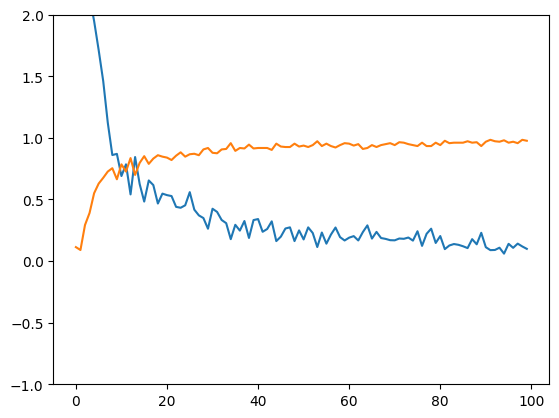

In [29]:
BS = 256
loss_func = nn.CrossEntropyLoss()

losses, accuracies = [], []

for i in (t:= trange(100)):
  samp = np.random.randint(0,X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp]).float()
  Y = torch.tensor(Y_train[samp]).long()
  optimizer.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat==Y).float().mean()
  loss = loss_func(out, Y)
  loss.backward()
  optimizer.step()

  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)

  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-1,2)
plot(losses)
plot(accuracies)

In [30]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.964